In [1]:
# globally useful imports of standard libraries needed in this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from datetime import datetime

# specific libraries or classes needed for the work in this notebook
#from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LogisticRegressionCV
#from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
#from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFpr, f_regression, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.pipeline import Pipeline
# need to use Pipeline from imblearn to add in a downsample or upsample
# to cross validation training
from imblearn.pipeline import Pipeline

# import project specific modules used in this notebook
import sys
sys.path.append('../src')
import mindwandering.data
import mindwandering.features
import mindwandering.evaluate
from mindwandering.data import FeatureScalerTransformer
from mindwandering.data import WinsorizationOutlierTransformer
from mindwandering.data import VIFThresholdTransformer
from mindwandering.data import FeatureSelectionTransformer
from mindwandering.data import ClassImbalanceTransformer
from mindwandering.data import GridSearchProgressHack

In [2]:
# Load Data and Features
df_features = mindwandering.data.get_df_features()
mind_wandered_label = mindwandering.data.get_mind_wandered_label()
participant_ids = mindwandering.data.get_participant_ids()

# vif thresholds to apply to data and labels before grid search pipeline
#vif_thresholds = [0, 5]
vif_thresholds = [0]

# we want to actually select a certain percentage of features of whatever remains
# after vif thresholding.  So we will calculate these in the loop based on the number
# of features in data, and add to the parameters dictionary before the grid search
#features__k_ratios = np.array([0.25, 0.5, 0.75, 1.0])
features__k_ratios = np.array([0.2, 0.25, 0.3, 0.35, 0.4, 0.5])

# Empty dataframe to gather grid search results into 1 place
best_estimator = None
best_score = 0.0
best_params = {}
best_index = 0
df_result = None

# search over vif threshold meta parameters, create separate df from vif_threshold
# for otherwise identical grid searches
for vif_threshold in vif_thresholds:
    # display progress
    print('')
    print('=' * 50)
    print('Starting vif meta-parameter condition: vif_threshold: ', vif_threshold)
    
    # pipeline to apply vif threshold selection
    vif_pipeline = Pipeline(
      [
        ('vif',      VIFThresholdTransformer(score_threshold=vif_threshold)),
      ]
    )
 
    df_vif_features = vif_pipeline.transform(df_features)
    num_trials, num_features = df_vif_features.shape
    print('   Number of trials: ', num_trials, ' Number of Features: ', num_features)
    
    parameters = {
        'scaling__type_of_scaling': ['standard'],
        'outlier__outlier_threshold': [0.0, 3.0],
        'features__score_func': [f_classif],
        #'balance__balancer_type': ['random-undersampler', 'allknn', 'nearmiss', 'instance-hardness-threshold'],
        #'balance__balancer_type': ['allknn', 'condensed-nn', 'neighbourhood-cleaning', 'one-sided-selection'],
        #'balance__balancer_type': ['allknn', 'one-sided-selection'],
        'balance__balancer_type': ['allknn', 'smote-enn'],
        'model__var_smoothing': [1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12]
    }

    # set feature selection k correctly
    features__k = features__k_ratios * num_features
    features__k = features__k.astype(int) 
    parameters['features__k'] = features__k.tolist()

    # Estimator Pipeline
    pipeline = Pipeline(
      [
        ('progress', GridSearchProgressHack(verbose=False)),
        ('scaling',  FeatureScalerTransformer()),
        ('outlier',  WinsorizationOutlierTransformer()),
        ('features', SelectKBest()),
        #('features', SelectFromModel(estimator=LogisticRegression(solver='liblinear', penalty='l1', C=0.1), threshold=-np.inf)),
        ('balance',  ClassImbalanceTransformer()),
        ('model',    GaussianNB()),
      ]
    )
    
    # Cross Validation Splitter
    cv_group_splitter = GroupKFold(n_splits=5)
    #cv_group_splitter = LeaveOneGroupOut()

    # perform the grid search for this vif selection
    # set up the search
    search = GridSearchCV(
        estimator = pipeline,
        param_grid = parameters,
        scoring = ['roc_auc', 'accuracy'],
        cv = cv_group_splitter,
        refit = 'roc_auc',
        verbose = 1
    )
    search.fit(df_vif_features, mind_wandered_label, groups=participant_ids)
    
    # append results onto the dataframe collecting the results.  Need to add
    # a feature column to this dataframe for the vif vit condition here
    df = pd.DataFrame(data=search.cv_results_)
    df['param__vif_score_threshold'] = vif_threshold
    
    if best_estimator is None:
        df_result = df
        best_estimator = search.best_estimator_
        best_score = search.best_score_
        best_params = search.best_params_
        best_index = search.best_index_
    else:
        df_result = df_result.append(df, ignore_index=True)
        if search.best_score_ > best_score:
            best_estimator = search.best_estimator_
            best_score = search.best_score_
            best_params = search.best_params_
            best_index = search.best_index_  # todo this is only the index of this search


Starting vif meta-parameter condition: vif_threshold:  0
   Number of trials:  4076  Number of Features:  62
Fitting 5 folds for each of 168 candidates, totalling 840 fits
0001 0002 0003 0004 0005 0006 0007 0008 0009 0010 0011 0012 0013 0014 0015 0016 0017 0018 0019 0020 0021 0022 0023 0024 0025 0026 0027 0028 0029 0030 0031 0032 0033 0034 0035 0036 0037 0038 0039 0040 0041 0042 0043 0044 0045 0046 0047 0048 0049 0050 0051 0052 0053 0054 0055 0056 0057 0058 0059 0060 0061 0062 0063 0064 0065 0066 0067 0068 0069 0070 0071 0072 0073 0074 0075 0076 0077 0078 0079 0080 0081 0082 0083 0084 0085 0086 0087 0088 0089 0090 0091 0092 0093 0094 0095 0096 0097 0098 0099 0100 0101 0102 0103 0104 0105 0106 0107 0108 0109 0110 0111 0112 0113 0114 0115 0116 0117 0118 0119 0120 0121 0122 0123 0124 0125 0126 0127 0128 0129 0130 0131 0132 0133 0134 0135 0136 0137 0138 0139 0140 0141 0142 0143 0144 0145 0146 0147 0148 0149 0150 0151 0152 0153 0154 0155 0156 0157 0158 0159 0160 0161 0162 0163 0164 0165 01

In [3]:
# top 20 performers by the test_roc_auc score
#,'param_model__max_features'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#res_cols = ['mean_test_roc_auc', 'mean_test_accuracy', 'param_balance__balancer_type', 'param_features__k', 
#            'param_features__score_func', 'param_model__C', 'param_model__solver', 
#            'param_outlier__outlier_threshold', 'param__vif_score_threshold']
res_cols = ['mean_test_roc_auc', 'mean_test_accuracy', 'param_balance__balancer_type',
            'param_features__k', 'param_model__var_smoothing',
            'param_outlier__outlier_threshold']
"""res_cols = ['mean_test_roc_auc', 'mean_test_accuracy', 'param_balance__balancer_type', 'param_model__var_smoothing',
            'param_outlier__outlier_threshold']"""
df_sorted = df_result[res_cols].reset_index(drop=True).sort_values('mean_test_roc_auc', axis=0, ascending=False)
df_sorted.index = pd.RangeIndex(1, len(df_sorted.index)+1)
df_sorted

,mean_test_roc_auc,mean_test_accuracy,param_balance__balancer_type,param_features__k,param_model__var_smoothing,param_outlier__outlier_threshold
1,0.659468,0.641563,allknn,12,1e-06,3
2,0.659468,0.641563,allknn,12,1e-07,3
3,0.659468,0.641563,allknn,12,1e-08,3
4,0.659468,0.641563,allknn,12,1e-09,3
5,0.659468,0.641563,allknn,12,1e-10,3
6,0.659468,0.641563,allknn,12,1e-11,3
7,0.659468,0.641563,allknn,12,1e-12,3
8,0.658794,0.645979,allknn,12,1e-06,0
9,0.658793,0.645979,allknn,12,1e-07,0
10,0.658793,0.645979,allknn,12,1e-08,0


In [4]:
# the average roc-auc and accuracy scores of just completed search.
# these are the averages of each model over the convolution folds.
#print(df_result['mean_test_roc_auc'])
#print(df_result['mean_test_accuracy'])
print(best_params)

{'balance__balancer_type': 'allknn', 'features__k': 12, 'features__score_func': <function f_classif at 0x7ff3d2e7b4c0>, 'model__var_smoothing': 1e-06, 'outlier__outlier_threshold': 3.0, 'scaling__type_of_scaling': 'standard'}


Accuracy score:         0.6484298331697743
Recall (TPR) score:     0.5696316262353999
Precision score:        0.3992443324937028
AUC-ROC score:          0.6238303254362959

True positives:   634
True negatives:   2009
False positives:  954
False negatives:  479
True Positive Rate (recall):  0.5696316262353999
False Positive Rate:          0.32197097536280794
Specificity:                  0.6780290246371921

[[2009  954]
 [ 479  634]]


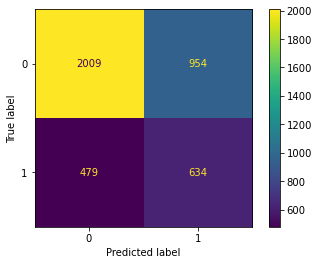

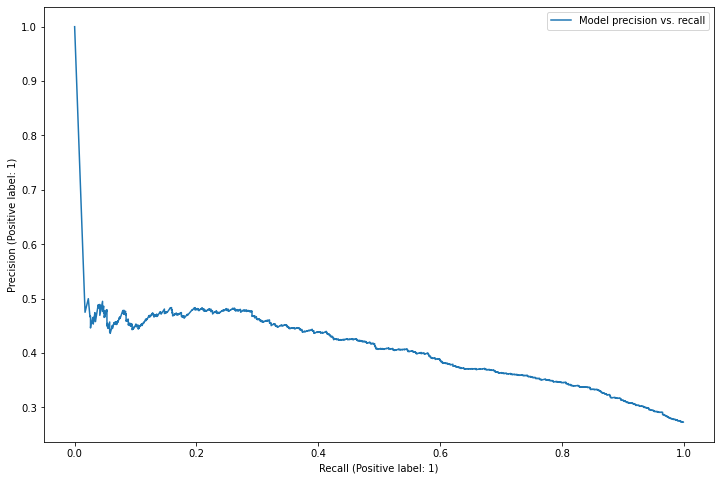

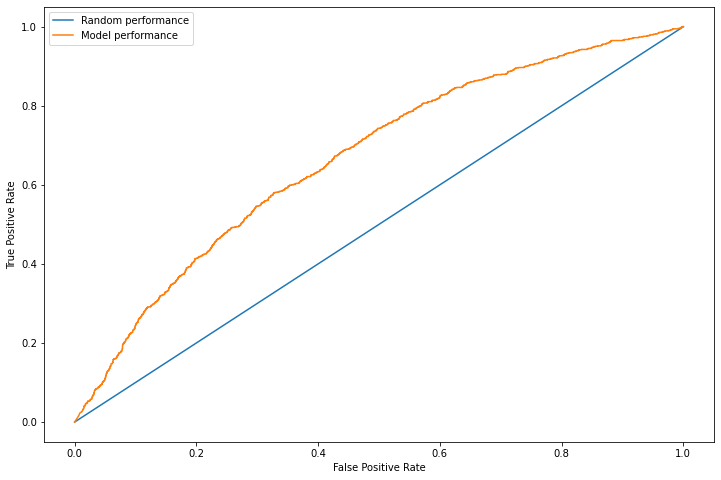

In [5]:
# display results for the best estimator we found
predictions = best_estimator.predict(df_features)
probabilities = best_estimator.predict_proba(df_features)[:,1]
mindwandering.evaluate.evaluate_model_results(mind_wandered_label, predictions, probabilities)

In [6]:
# save the results and preliminary figures in the following cells

# create base save file name for this file, use datetime to keep a unique file name
now = datetime.now()
date_time = now.strftime('%Y%m%d-%H%M')
result_file_basename = 'replication-05-Naive-Bayes-' + date_time
print(result_file_basename)

replication-05-Naive-Bayes-20210505-0323


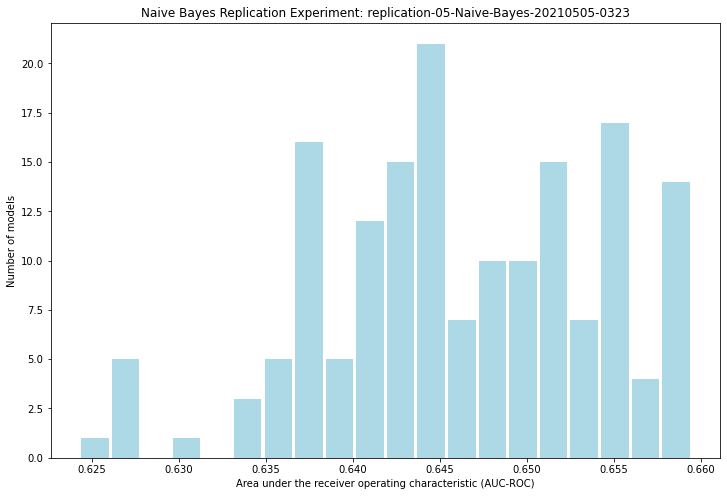

In [7]:
# A quick histogram of this search auc-roc scores.  Basically the figure 1 from the paper.
plt.figure(figsize=(12,8))

#bins = np.linspace(0.605, 0.612, 8)
plt.hist(df_result.mean_test_roc_auc, 
         bins=20,
         color='lightblue',
         rwidth=0.9);
plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.ylabel('Number of models');
plt.title('Naive Bayes Replication Experiment: ' + result_file_basename);

result_dir = '../figures'
result_file_name = result_file_basename + '.eps'
result_file_path = os.path.join(result_dir, result_file_name)
plt.savefig(result_file_path)

In [8]:
# save the search results dataframe to a file so can retrieve for later data analysis or
# to combine with other grid search results for summaries
result_dir = '../results'
result_file_name = result_file_basename + '.pkl'
result_file_path = os.path.join(result_dir, result_file_name)
df_result.to_pickle(result_file_path)